# Generating Essays Using an Iterative, AI-Agent Approach with LangGraph

<a target="_blank" href="https://colab.research.google.com/github/koverholt/gemini-agent-ai-camp/blob/main/3-langgraph-essay/langgraph-essay.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to generate, revise, and critique essays using large language models such as Google's [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs) or the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview). The LangGraph code was adapted from the awesome DeepLearning.AI course on [AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/).

By defining a structured state flow with nodes such as "Planner," "Research Plan," "Generate," "Reflect," and "Research Critique," the system iteratively creates an essay on a given topic, incorporates feedback, and provides research-backed insights.

<img src="../images/3-langgraph-essay.png" width="900px">

The workflow enables automated essay generation with revision controls, making it ideal for structured writing tasks or educational use cases. Additionally, the notebook uses external search tools to gather and integrate real-time information into the essay content.

## Install packages

In [1]:
!pip install -q -U \
    langgraph \
    langchain \
    langchain-google-genai \
    langchain-google-vertexai \
    tavily-python \
    pydantic

## Import libraries

In [2]:
# Common libraries
import os
import json
import operator
from IPython.display import Image, display, Markdown
from pprint import pprint

# LangChain and LangGraph components
from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
    ChatMessage,
)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END

# Typing utilities for data validation and schema definitions
from pydantic.v1 import BaseModel
from typing import TypedDict, Annotated, List

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI

# Tavily client for performing web searches
from tavily import TavilyClient

## Initialize agent memory, agent state, and schema for search queries

In [3]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int


# Define a schema for search queries
class Queries(BaseModel):
    """Variants of query to search for"""

    queries: List[str]

## Configure API keys

Get API keys from [Google AI Studio](https://ai.google.dev/gemini-api/docs/api-key) and [Tavily](https://tavily.com/).

In [4]:
import os
import sys

# Get API keys from Colab Secrets
if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
    os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
# Or, define API keys directly in notebook
else:
    os.environ["GOOGLE_API_KEY"] = "INPUT_YOUR_GOOGLE_AI_STUDIO_API_KEY"
    os.environ["TAVILY_API_KEY"] = "INPUT_YOUR_TAVILY_API_KEY"

## Initialize Gemini model and search tool

Remember to set the environment variables `GOOGLE_API_KEY` and `TAVILY_API_KEY`. And configure credentials for Vertex AI if you switch to it.

In [5]:
# Initialize Gemini API in Google AI Studio via LangChain
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro-002", temperature=0)

# Initialize Gemini API in Vertex AI via LangChain
# model = ChatVertexAI(model="gemini-1.5-pro-002", temperature=0)

# Initialize Tavily client for performing web searches
tavily = TavilyClient()

## Define prompt templates for each stage

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any
relevant notes or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 3-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Use Markdown formatting to specify a title and section headers for each paragraph.
Utilize all of the information below as needed:
---
{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can
be used when writing the following essay. Generate a list of search queries that will gather
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information.
Only generate 3 queries max."""

## Define node functions for each stage

In [7]:
# Generate an outline for the essay
def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan": response.content}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state["task"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## Define and compile the graph

In [8]:
# Initialize the state graph
builder = StateGraph(AgentState)

# Add nodes for each step in the workflow
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the entry point of the workflow
builder.set_entry_point("planner")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

# Define task sequence edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile the graph with memory state management
graph = builder.compile(checkpointer=memory)

## Show the compiled graph

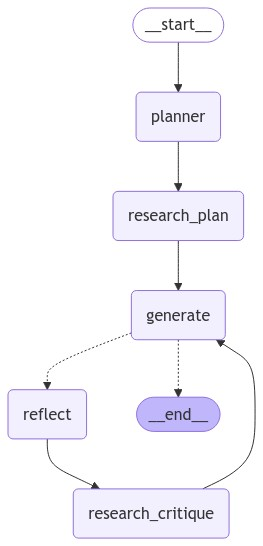

In [9]:
Image(graph.get_graph().draw_mermaid_png())

## Run the agent - write on!

In [10]:
# Define the topic of the essay
ESSAY_TOPIC = "What were the impacts of Hurricane Helene in 2024?"

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}

# Stream through the graph execution with an initial task and state
for s in graph.stream(
    {
        "task": ESSAY_TOPIC,  # Initial task
        "max_revisions": 2,  # Maximum number of revisions allowed
        "revision_number": 1,  # Current revision number
        "content": [],  # Initial empty content list
    },
    thread,
):
    pprint(s)  # Output each step in the stream
    print("\n---\n")

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'planner': {'plan': '## Essay Outline: Impacts of Hurricane Helene (2024)\n'
                     '\n'
                     '**I. Introduction**\n'
                     '    * Briefly introduce Hurricane Helene, its formation, '
                     'and its path.\n'
                     "    * State the essay's purpose: to examine the "
                     'multifaceted impacts of the hurricane.\n'
                     '    * Briefly preview the main areas of impact that will '
                     'be discussed (e.g., environmental, economic, social).\n'
                     '    * **Note:** Keep the introduction concise and '
                     'engaging.  Establish the scope of the essay (e.g., '
                     'specific geographic areas affected).\n'
                     '\n'
                     '**II. Environmental Impacts**\n'
                     '    * **Coastal Erosion and Damage:** Detail the extent '
                     'of coastline affected, specific examples 

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'reflect': {'critique': 'This essay is a good starting point and covers the '
                         'major impacts of a hurricane. However, it lacks '
                         'depth and specific examples, making it read more '
                         'like a generalized report than a compelling '
                         "analysis. Here's a breakdown of my critique and "
                         'recommendations:\n'
                         '\n'
                         '**Strengths:**\n'
                         '\n'
                         '* **Structure:** The essay follows a logical '
                         'structure, addressing environmental, economic, and '
                         'social impacts before concluding with recovery and '
                         'future implications.\n'
                         '* **Clear Topic Sentences:** Each paragraph begins '
                         'with a clear topic sentence that outlines the main '
                         'point

## Output the final draft of the essay

In [11]:
display(Markdown(s["generate"]["draft"]))

## The Devastating Impacts of Hurricane Helene (2024)

Hurricane Helene, a powerful Category 4 storm, made landfall near Perry, Florida, in late September 2024.  Its 140 mph winds and torrential rains carved a path of destruction across the Southeast, impacting Florida, Georgia, South Carolina, North Carolina, Tennessee, and Virginia. This essay will examine the multifaceted impacts of Hurricane Helene, focusing on the environmental, economic, and social consequences of this devastating storm.  The storm's widespread effects, spanning nearly 400 miles from Florida's Big Bend to Asheville, North Carolina, underscore the vulnerability of communities to extreme weather events.

## Environmental Devastation and Health Risks

Hurricane Helene’s environmental impact was severe and far-reaching. Coastal areas experienced significant erosion, reshaping shorelines and threatening coastal ecosystems.  Inland, flooding caused widespread water damage, contaminating water sources and overflowing sewage systems.  The flooding in the North Carolina mountains, in particular, posed significant health risks, as access to clean water and power was cut off for many residents.  The storm also disrupted wildlife, displacing animal populations, damaging nesting sites, and upsetting the delicate balance of natural habitats.  Reports from affected areas highlighted the rising health concerns in the aftermath of the flooding, including waterborne illnesses and the psychological toll on affected communities.

## Economic Fallout and Recovery Efforts

The economic fallout from Hurricane Helene was substantial.  Early estimates suggest total damages and economic losses could reach as high as $160 billion.  The storm inflicted widespread damage to infrastructure, including roads, bridges, and buildings, disrupting transportation and communication networks. Key industries, such as tourism and agriculture, suffered significant losses.  The sheer volume of insurance claims filed underscored the scale of the disaster, and many individuals and businesses faced challenges in obtaining timely financial aid.  While government assistance programs played a crucial role in supporting recovery efforts, the long-term economic recovery prospects for the affected regions remain uncertain.  The storm's impact on industries and infrastructure highlighted the interconnectedness of economic systems and the vulnerability of supply chains to disruptions.

## Social Upheaval and Community Resilience

Hurricane Helene caused significant social upheaval, displacing thousands of people from their homes and creating a housing crisis in affected areas.  Vulnerable populations were particularly hard hit, facing challenges in accessing essential resources and finding safe shelter.  The storm also exacerbated existing health disparities, as access to healthcare services was limited in some areas.  Despite the widespread devastation, communities demonstrated remarkable resilience, rallying together to support those in need.  Community organizations and volunteers played a vital role in providing shelter, food, and emotional support to displaced residents.  Stories of neighbors helping neighbors emerged as a testament to the strength and compassion of the human spirit in the face of adversity.  The long-term process of rebuilding and recovery will require sustained effort and collaboration among government agencies, community organizations, and individuals.
